<a href="https://colab.research.google.com/github/SC1DR-OFFICIAL/GAN-MNIST-Fashion/blob/main/GAN_MNIST_Fashion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement

**Goal:** Compare two different DCGAN architectures (classic and improved) on the task of generating clothing images from the Fashion-MNIST dataset. Draw conclusions about their effectiveness.

**Action Plan:**
1. Load and prepare the Fashion-MNIST dataset.
2. Implement both generator and discriminator models.
3. Train both GAN models (sequentially) on the same dataset:
   - Use the same latent vector size.
   - Use the same number of epochs.
   - Use the same training parameters.
4. Perform a **comparative analysis** of the results.
5. Make **conclusions** — which architecture trained faster, generated more realistic images, and had better stability.

# Loading the Fashion-MNIST Dataset

Importing libraries

In [1]:
# Working with images
from PIL import Image
import imageio
import cv2
from keras.preprocessing.image import img_to_array

# Linear algebra library
import numpy as np

# Working with the file system and system functions
import os

# Data preprocessing
from keras import preprocessing
import tensorflow as tf

# Building the network
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, Dense, Flatten, Conv2DTranspose, BatchNormalization, LeakyReLU, Reshape

# Visualization of processes and loops
from tqdm import tqdm

# Random number generation
import re

# Working with plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Disable unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

Loading the Fashion MNIST dataset

In [2]:
(train_images, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Let's check the image sizes

In [3]:
print("Shape of train_images:", train_images.shape)
print("Data type:", train_images.dtype)

Shape of train_images: (60000, 28, 28)
Data type: uint8


Let's define variables for our model and input images

In [4]:
SIZE = 28                     # image size per dimension
INPUT_IMG = (SIZE, SIZE, 1)   # grayscale image → 1 channel
BATCH_SIZE = 32               # batch size for training
LATENT_DIM = 100              # dimensionality of the latent space
EPOCHS = 50                   # number of training epochs

Load images into a tensor, scaling them to the range $[-1, 1]$, since we will use the `tanh` activation function in the output layer of the generator.


In [5]:
images = []
for img in train_images:
    # Do not convert to RGB — keep as 1 channel
    img_pil = Image.fromarray(img)

    # Optional: resize (if SIZE ≠ 28)
    if SIZE != 28:
        img_pil = img_pil.resize((SIZE, SIZE))

    # Convert to float32 array and normalize to [-1, 1]
    img_array = np.array(img_pil).astype(np.float32)
    img_array = (img_array - 127.5) / 127.5

    # Add channel dimension: (H, W) → (H, W, 1)
    img_array = np.expand_dims(img_array, axis=-1)

    images.append(img_array)

X_train = np.array(images)

Generate a dataset with batching from the NumPy image tensor.  
Using the `Dataset` class allows the Keras framework (or more precisely, TensorFlow as its backend) to optimize computations, primarily saving RAM.


In [6]:
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size=len(X_train)).batch(BATCH_SIZE)

### Data Visualization

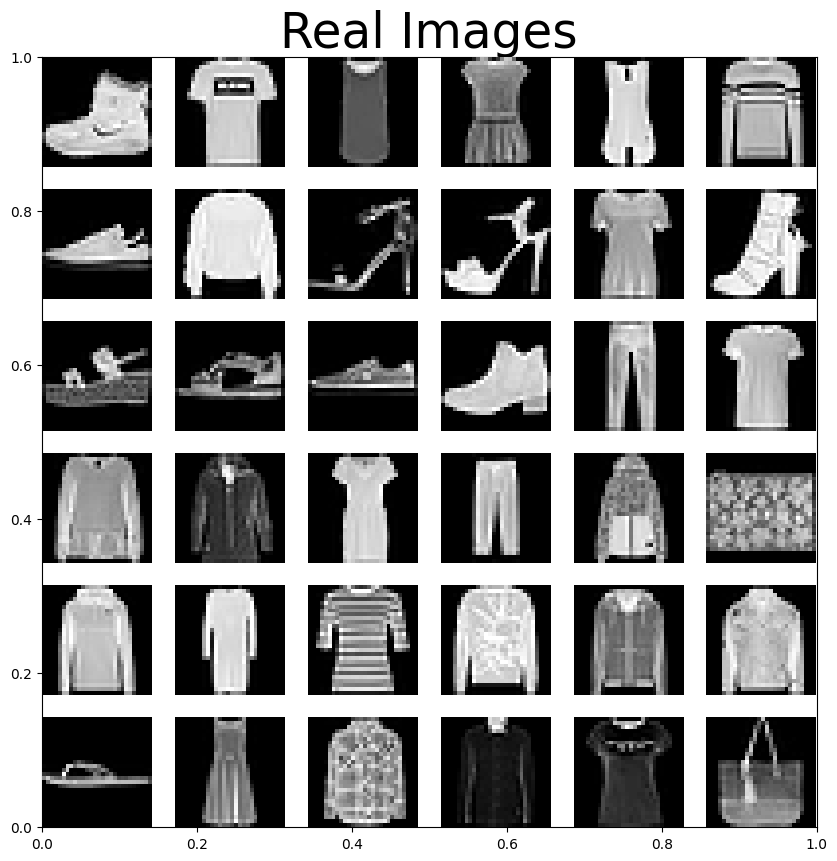

In [7]:
def plot_images(sqr=5):
    plt.figure(figsize=(10, 10))
    plt.title("Real Images", fontsize=35)
    for i in range(sqr * sqr):
        plt.subplot(sqr, sqr, i+1)
        plt.imshow(X_train[i] * 0.5 + 0.5, cmap="gray")
        plt.axis('off')

# To plot images
plot_images(6)

# Model architecture

The model architecture consists of a generator and a discriminator.

## Classic DCGAN

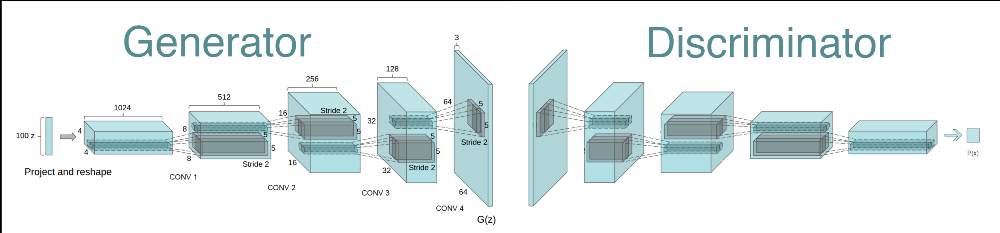

DCGAN (Deep Convolutional GAN) consists of two main components:

* Generator — creates images from random noise.
* Discriminator — determines whether the images are real or generated.


**Classic DCGAN** builds an image from a noise vector of shape (100,) by progressively increasing the resolution through `Conv2DTranspose` layers. The architecture is linear, strictly directed from bottom to top: from low resolution (4×4) to the final (28×28×1). This makes the structure simple and efficient but with limited capability to reconstruct complex details.

#### Generator

In [8]:
def GeneratorClassic():
    model = Sequential()

    # 7x7x128 — immediately approximate to 28x28 to make only 2 upsamplings
    model.add(tf.keras.layers.Dense(7*7*128, use_bias=False, input_shape=(LATENT_DIM,)))
    model.add(tf.keras.layers.Reshape((7, 7, 128)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    # 14x14x64
    model.add(tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    # 28x28x1
    model.add(tf.keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding='same', activation='tanh'))

    return model

In [9]:
generator_classic = GeneratorClassic()
generator_classic.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 6272)           │       627,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 1)      │         1,601 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 834,369 (3.18 MB)

 Trainable params: 833,985 (3.18 MB)

 Non-trainable params: 384 (1.50 KB)

#### Discriminator

In [10]:
def DiscriminatorClassic():
    model = Sequential()

    # 28x28x1 → 14x14x64
    model.add(tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding='same', input_shape=(28, 28, 1)))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.Dropout(0.3))

    # 14x14x64 → 7x7x128
    model.add(tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding='same'))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.Dropout(0.3))

    # 7x7x128 → flat → 1
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    return model

In [11]:
discriminator_classic = DiscriminatorClassic()
discriminator_classic.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

## Improved DCGAN

**Improved GAN** uses a deeper architecture that includes both downsampling (`Conv2D` with `strides=2`) and upsampling (`Conv2DTranspose`). It starts by creating an image of size 28×28×1, which is then compressed and reconstructed, resembling an autoencoder. This allows the model to better capture global and local patterns, which is especially useful when generating complex structures such as clothing elements.


#### Generator

In [12]:
def GeneratorImproved():
    model = Sequential()

    # Start with a 7x7x128 tensor (like DCGAN, but with down→up)
    model.add(Dense(7*7*128, use_bias=False, input_shape=(LATENT_DIM,)))
    model.add(Reshape((7, 7, 128)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    # Downsampling (effectively works like feature convolution)
    model.add(Conv2D(128, 3, strides=1, padding='same', use_bias=False, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(64, 3, strides=1, padding='same', use_bias=False, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    # Upsampling to 14x14
    model.add(Conv2DTranspose(64, 4, strides=2, padding='same', use_bias=False, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    # To 28x28
    model.add(Conv2DTranspose(32, 4, strides=2, padding='same', use_bias=False, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    # Output layer: 28x28x1
    model.add(Conv2DTranspose(1, 3, strides=1, padding='same', activation='tanh'))

    return model

In the convolutions, we use weight initialization `kernel_initializer='he_normal'` and do not use biases (`use_bias=False`). This weight initialization is standard for computer vision tasks: the weights are initialized with values close to zero and normally distributed. For details, refer to the original [paper](https://arxiv.org/pdf/1502.01852).

Note that `he_normal` is a compound name for the initializer: `He` is the surname of the author, and `normal` indicates the normal distribution.


In [13]:
generator_improved = GeneratorImproved()
generator_improved.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 6272)           │       627,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 64)       │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 14, 14, 64)     │        65,536 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 28, 28, 32)     │        32,768 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 948,641 (3.62 MB)

 Trainable params: 947,809 (3.62 MB)

 Non-trainable params: 832 (3.25 KB)

#### Discriminator

The discriminator model takes images of size 28 by 28 by 1, which can be either real or generated. The input image undergoes downsampling using a `Conv2D` layer and is finally flattened with a `Flatten` layer and passed to a single neuron to distinguish between real and fake images. Since the last layer uses a sigmoid activation function, it outputs a value in the range from 0 to 1. Here, a value greater than 0.5 indicates a real image, while a value less than 0.5 indicates a fake one. The discriminator’s output is also used during the training of the generator.

In [14]:
def DiscriminatorImproved():
    model = Sequential()

    # 28x28x1 → 14x14x64
    model.add(Conv2D(64, 4, strides=2, padding='same', input_shape=(28, 28, 1),
                     kernel_initializer='he_normal', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    # 14x14x64 → 7x7x128
    model.add(Conv2D(128, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    # 7x7x128 → 4x4x256
    model.add(Conv2D(256, 4, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    # Flatten and output
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [15]:
discriminator_improved = DiscriminatorImproved()
discriminator_improved.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 128)      │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 7, 7, 256)      │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 670,721 (2.56 MB)

 Trainable params: 669,825 (2.56 MB)

 Non-trainable params: 896 (3.50 KB)

Let's plot the image generated by the generator before training.

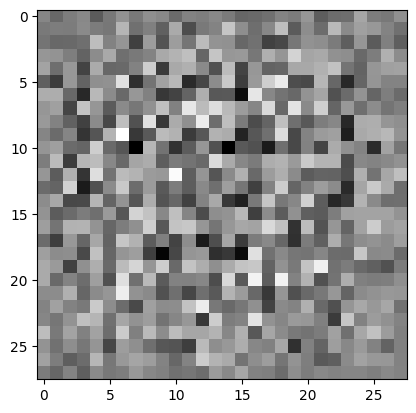

In [16]:
noise = np.random.normal(-1,1,(1,LATENT_DIM))
img = generator_improved(noise)
plt.imshow(img[0,:,:,0], cmap="gray")
plt.show()

An untrained generator creates new noise from noise!

# Model training

## Definition of loss function and optimizer

Next, it is necessary to define the loss function and optimizers for the generator and discriminator.

**IMPORTANT:** you must define separate optimizers for the generator and the discriminator. Although they are identical, using a shared optimizer will lead to an error during training.

As the optimizer, we will use `Adam` with parameters `learning_rate=0.0002` and `beta_1=0.5`. As the loss function, we will use binary cross-entropy.


In [17]:
optimizer_G = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
optimizer_D = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# This creates a helper function for computing binary cross-entropy losses
cross_entropy = tf.keras.losses.BinaryCrossentropy()

Based on binary cross-entropy, we define a loss function for the discriminator. This function should quantify how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions for real images with an array of ones (of the same shape as the image), and the discriminator's predictions for fake (generated) images with an array of zeros (of the same shape as the image). The resulting comparison errors are summed up.

In [18]:
def discriminator_loss(fake_output, real_output):
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    return fake_loss + real_loss

As for the generator's loss function, things are simpler. The generator's loss function quantifies how well it was able to fool the discriminator. Intuitively, if the generator works well, the discriminator will classify fake images as real (equal to one). Therefore, the error function for the discriminator returns the binary cross-entropy error from comparing a fake image to one (the identity matrix).

In [19]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Training a Classical DCGAN Model

We define a single training step. The training cycle begins with the generator receiving random noise as input, which is used to generate an image. The discriminator is then used to classify real images (extracted from the training set) and fake images (generated by the generator). A loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

To train the generator and discriminator simultaneously, we need a lower-level approach for training and evaluation loops than what `fit()` and `evaluate()` provide, so we will have to write our own. Actually, this is quite straightforward! But be prepared for more debugging.

Low-level training involves computing gradients, which is done using `GradientTape`.

Calling the model within the scope of `GradientTape` allows us to obtain the gradients of the trainable layer weights with respect to the loss value. Using an optimizer instance, we will apply these gradients to update the model weights.

We will use mini-batch gradient descent with a custom training loop. Details are provided in the comments within the code.


In [20]:
# We use the `tf.function` decorator, though it also works without it.
# It tells TensorFlow to compile this function, optimizing the training process.
@tf.function
def train_steps(images):

    # Generate noise as input to the generator
    noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))

    # Initialize separate GradientTapes for the discriminator and generator
    # to record operations during the forward pass, enabling automatic differentiation.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Run a forward pass of the noise through the generator.
        # Each operation applied by a layer to its inputs is recorded on the GradientTape,
        # similar to a tape recorder — hence the name "gradient tape".
        generated_images = generator_classic(noise)

        # Also run a forward pass through the discriminator
        # for both real and fake images
        fake_output = discriminator_classic(generated_images)
        real_output = discriminator_classic(images)

        # Compute loss functions (loss values)
        gen_loss = generator_loss(fake_output)
        dis_loss = discriminator_loss(fake_output, real_output)

    # Use the gradient tapes to automatically compute gradients
    # of the trainable variables with respect to the losses.
    gradient_of_generator = gen_tape.gradient(gen_loss, generator_classic.trainable_variables)
    gradient_of_discriminator = disc_tape.gradient(dis_loss, discriminator_classic.trainable_variables)

    # Perform one step of gradient descent by updating
    # the variables to minimize the losses.
    optimizer_G.apply_gradients(zip(gradient_of_generator, generator_classic.trainable_variables))
    optimizer_D.apply_gradients(zip(gradient_of_discriminator, discriminator_classic.trainable_variables))

    # Return the loss values for visualization
    loss = {
        'gen_loss': gen_loss,
        'disc_loss': dis_loss
    }
    return loss


Next, we will write the `train()` function, which runs the training loop for each epoch. The generator and discriminator must be trained simultaneously without overpowering each other, so it is important that they are trained at the same pace.


In [21]:
import time

def train(epochs, dataset):
    D_loss = []  # list to collect discriminator loss values
    G_loss = []  # list to collect generator loss values
    for epoch in range(epochs):
        start = time.time()
        print("\nEpoch: {}".format(epoch + 1))
        for images in dataset:
            loss = train_steps(images)
        print(" Time: {}".format(np.round(time.time() - start, 2)))
        print("Generator Loss: {} Discriminator Loss: {}".format(loss['gen_loss'], loss['disc_loss']))
        D_loss.append(loss['disc_loss'])
        G_loss.append(loss['gen_loss'])
    return (G_loss, D_loss)

In [22]:
G_classic, D_classic = train(EPOCHS, dataset)


Epoch: 1
 Time: 12.65
Generator Loss: 0.7083946466445923 Discriminator Loss: 1.366499662399292

Epoch: 2
 Time: 9.24
Generator Loss: 0.796553373336792 Discriminator Loss: 1.3222815990447998

Epoch: 3
 Time: 9.23
Generator Loss: 0.7289092540740967 Discriminator Loss: 1.3263421058654785

Epoch: 4
 Time: 9.3
Generator Loss: 0.7473308444023132 Discriminator Loss: 1.391557216644287

Epoch: 5
 Time: 9.21
Generator Loss: 0.7235088348388672 Discriminator Loss: 1.3564952611923218

Epoch: 6
 Time: 9.25
Generator Loss: 0.6904101371765137 Discriminator Loss: 1.3846501111984253

Epoch: 7
 Time: 9.31
Generator Loss: 0.7014346122741699 Discriminator Loss: 1.3056683540344238

Epoch: 8
 Time: 9.2
Generator Loss: 0.8120253086090088 Discriminator Loss: 1.2750792503356934

Epoch: 9
 Time: 9.2
Generator Loss: 0.8697936534881592 Discriminator Loss: 1.0812621116638184

Epoch: 10
 Time: 9.26
Generator Loss: 1.4341529607772827 Discriminator Loss: 0.896003246307373

Epoch: 11
 Time: 9.19
Generator Loss: 1.5223

# Image generation using classical DCGAN model

In [23]:
def plot_generated_images(square = 5):


  plt.figure(figsize = (10,10))
  for i in range(square * square):
    plt.subplot(square, square, i+1)
    noise = np.random.normal(0,1,(1,LATENT_DIM))
    img = generator_classic(noise)
    plt.imshow(np.clip((img[0,...]+1)/2, 0, 1), cmap="gray")

    plt.axis('off')
    plt.grid()

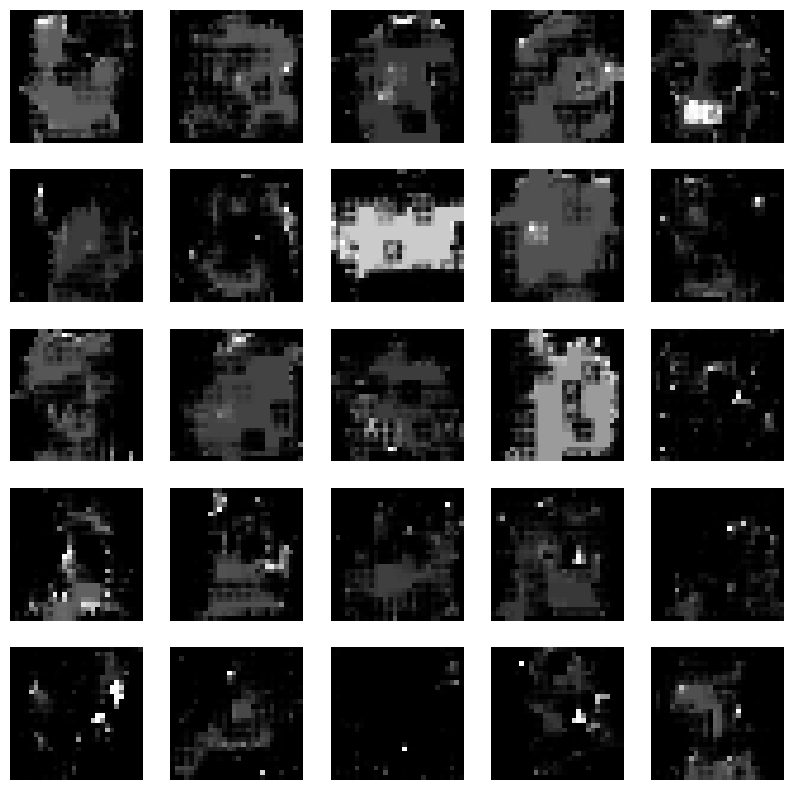

In [24]:
plot_generated_images(5)

## Training an improved DCGAN model

In [25]:
optimizer_G_improved = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
optimizer_D_improved = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# This creates a helper function for computing binary cross-entropy losses
cross_entropy_improved = tf.keras.losses.BinaryCrossentropy()

In [26]:
# We use the `tf.function` decorator, though it also works without it.
# It tells TensorFlow to compile this function, which optimizes the training process.
@tf.function
def train_steps_improved(images):

    # Generate noise as input to the generator
    noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))

    # Initialize separate GradientTapes for the discriminator and generator
    # to record operations during the forward pass, enabling automatic differentiation.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Run a forward pass of the noise through the generator.
        # Each operation applied by a layer to its inputs is recorded on the GradientTape,
        # like on a tape recorder — hence the name "gradient tape".
        generated_images = generator_improved(noise)

        # Also run a forward pass through the discriminator
        # for both real and fake images
        fake_output = discriminator_improved(generated_images)
        real_output = discriminator_improved(images)

        # Compute loss functions (loss values)
        gen_loss = generator_loss(fake_output)
        dis_loss = discriminator_loss(fake_output, real_output)

    # Use the gradient tapes to automatically compute gradients
    # of the trainable variables with respect to the losses.
    gradient_of_generator = gen_tape.gradient(gen_loss, generator_improved.trainable_variables)
    gradient_of_discriminator = disc_tape.gradient(dis_loss, discriminator_improved.trainable_variables)

    # Perform one step of gradient descent by updating
    # the variables to minimize the losses.
    optimizer_G_improved.apply_gradients(zip(gradient_of_generator, generator_improved.trainable_variables))
    optimizer_D_improved.apply_gradients(zip(gradient_of_discriminator, discriminator_improved.trainable_variables))

    # Return the loss values for visualization
    loss = {
        'gen_loss': gen_loss,
        'disc_loss': dis_loss
    }
    return loss

In [27]:
import time

def train_improved(epochs, dataset):
    D_loss = []  # list to collect discriminator loss values
    G_loss = []  # list to collect generator loss values
    for epoch in range(epochs):
        start = time.time()
        print("\nEpoch: {}".format(epoch + 1))
        for images in dataset:
            loss = train_steps_improved(images)
        print(" Time: {}".format(np.round(time.time() - start, 2)))
        print("Generator Loss: {} Discriminator Loss: {}".format(loss['gen_loss'], loss['disc_loss']))
        D_loss.append(loss['disc_loss'])
        G_loss.append(loss['gen_loss'])
    return (G_loss, D_loss)

In [28]:
G_improved, D_improved = train_improved(EPOCHS, dataset)


Epoch: 1
 Time: 20.39
Generator Loss: 0.8773735761642456 Discriminator Loss: 1.1802873611450195

Epoch: 2
 Time: 15.95
Generator Loss: 0.5361360311508179 Discriminator Loss: 1.187873125076294

Epoch: 3
 Time: 15.9
Generator Loss: 1.1137524843215942 Discriminator Loss: 1.1150360107421875

Epoch: 4
 Time: 15.98
Generator Loss: 0.8086948394775391 Discriminator Loss: 1.1832339763641357

Epoch: 5
 Time: 15.97
Generator Loss: 1.2886431217193604 Discriminator Loss: 1.1290979385375977

Epoch: 6
 Time: 16.01
Generator Loss: 1.1142117977142334 Discriminator Loss: 1.0133565664291382

Epoch: 7
 Time: 16.12
Generator Loss: 0.9564905762672424 Discriminator Loss: 0.9955548048019409

Epoch: 8
 Time: 16.04
Generator Loss: 1.0218620300292969 Discriminator Loss: 1.123611330986023

Epoch: 9
 Time: 16.36
Generator Loss: 1.2192373275756836 Discriminator Loss: 1.220460057258606

Epoch: 10
 Time: 15.89
Generator Loss: 1.3168909549713135 Discriminator Loss: 0.8566790223121643

Epoch: 11
 Time: 16.01
Generator

# Image Generation Using Improved DCGAN Model

In [29]:
def plot_generated_improved_images(square = 5):


  plt.figure(figsize = (10,10))
  for i in range(square * square):
    plt.subplot(square, square, i+1)
    noise = np.random.normal(0,1,(1,LATENT_DIM))
    img = generator_improved(noise)
    plt.imshow(np.clip((img[0,...]+1)/2, 0, 1), cmap="gray")

    plt.axis('off')
    plt.grid()

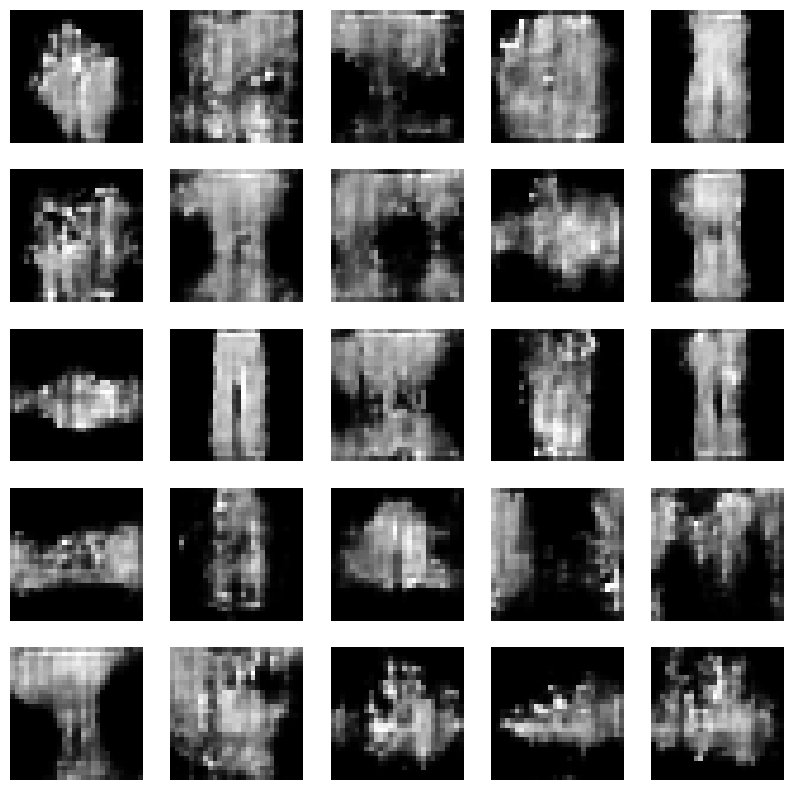

In [30]:
plot_generated_improved_images(5)

# Comparative analysis of models

* Training speed: According to the training log, the epochs of the classical model took about 9s, while the improved one took about 15s. The classical architecture learns faster.

* Image realism: DCGAN significantly outperforms classical GAN ​​on the Fashion-MNIST dataset in all visual features: clothing objects are recognizable, diverse and contain more details, while classical architecture has hardly left the “noise spots” stage.

* Stability. Losses fluctuate approximately equally in both models.